In [1]:
import os, sys, re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
eventid_list = np.array([
    # Planet/Binary
    '0328', '0570', '1196', '1860', '1914', 
    # Binary/Plan
    '0002', '0104', '0143', '0149', '0182',
    '0308', '0681', '0724', '1187', '1713',
    '2270', '2485', '3199', 
    # Binary
    '0021', '0200', '0209', '0236', '0270',
    '0325', '0335', '0342', '0343', '0386',
    '0412', '0535', '0561', '0609', '0649',
    '0651', '0787', '0819', '0967', '1182',
    '1195', '1281', '1291', '1334', '1363',
    '1524', '1576', '1679', '1686', '1689',
    '1700', '1722', '1850', '1984', '2063',
    '2142', '2279', '2286', '2298', '2309',
    '2324', '2496', '2596', '2599', '2655',
    '2667', '2769', '2840', '2842', '2888',
    ])

In [3]:
q = torch.tensor([
    # Planet/Binary
    0.4270, np.nan, 0.2342, np.nan, 0.234,
    # Binary/Plan
    np.nan, np.nan, 0.0367, 0.0480, np.nan,
    np.nan, np.nan, 0.1448, 0.1284, np.nan,
    0.1734, 0.4270, np.nan,
    # Binary
    0.234, 0.356, 0.0722, 0.50, 0.234, 
    0.169, 0.0461, 0.4062, 0.316, 0.19, 
    0.594, np.nan, np.nan, 0.3675, 0.2342,
    0.945, 0.576, 0.532, np.nan, 0.457,
    0.0951, 0.904, 0.3675, 0.3554, 0.721,
    0.4962, 0.110, 0.7786, 0.4199, 0.4962,
    0.8809, 0.730, 0.7357, 0.152, 0.5766,
    0.1492, 0.4270, 0.9607, 0.0858, 0.7555,
    np.nan, 0.6700, 0.693, 0.231, 0.55844,
    0.4962, 0.081, 0.7405, 0.6700, 0.2015,
])

In [4]:
s = torch.tensor([
    # Planet/Binary
    0.3325, np.nan, 0.2084, np.nan, 0.434,
    # Binary/Plan
    np.nan, np.nan, 0.946, 0.496, np.nan,
    np.nan, 1.010, 2.6540, 7.1626, np.nan,
    4.799, 6.2676, np.nan,
    # Binary
    3.674, 0.419, 0.49, 0.61, 6.700,
    1.086, 0.8625, 0.5430, 0.530, 1.10,
    2.049, np.nan, np.nan, 0.4342, 3.6747,
    1.304, 0.648, 1.9781, np.nan, 0.836,
    1.6496, 3.007, 1.7635, 0.8117, 2.858,
    3.2155, 2.015, 0.3554, 2.3031, 2.4621,
    1.5649, 0.596, 1.3634, 0.977, 3.0079,
    0.2084, 0.6480, 1.0780, 0.4847, 1.4483,
    np.nan, 0.332, 1.010, 0.898, 0.6555,
    1.1053, 0.406, 2.3733, 3.4374, 1.2887, 
])

In [5]:
targetdir = '/work/hmzhao/KMT_data/'
with h5py.File(targetdir + 'processed_data.h5', mode='r') as dataset_file:
    X_even = torch.tensor(dataset_file['X'][...]).float()
nanind = torch.where(~torch.isnan(q))[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
nanind = torch.where(~torch.isnan(s))[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
nanind = torch.where(s > 0.3)[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
nanind = torch.where(s < 3)[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
# nanind = torch.where(torch.max(X_even[:, :, 1], dim=1).values - torch.min(X_even[:, :, 1], dim=1).values > 2)[0]
# eventid_list = eventid_list[nanind]
# q = q[nanind]
# s = s[nanind]
# X_even = X_even[nanind]
nanind = torch.where(torch.max(X_even[:, :, 0], dim=1).values > 1)[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
nanind = torch.where(torch.min(X_even[:, :, 0], dim=1).values < - 1)[0]
eventid_list = eventid_list[nanind]
q = q[nanind]
s = s[nanind]
X_even = X_even[nanind]
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)
print(len(train_coeffs))

25


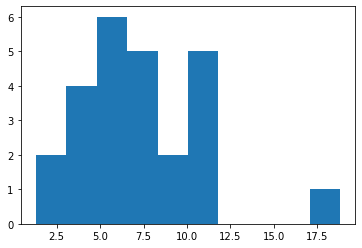

In [6]:
plt.hist((torch.max(X_even[:, :, 1], dim=1).values - torch.min(X_even[:, :, 1], dim=1).values).numpy())
plt.show()

In [7]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_3.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = 6
input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [8]:
def inference(model, total_size, batch_size, coeffs):
    num = total_size
    batchsize = batch_size
    n_gaussian = model.n_gaussian
    pis = torch.zeros((num, n_gaussian))
    locs = torch.zeros((num, n_gaussian, output_dim))
    scales = torch.zeros((num, n_gaussian, output_dim))
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(int(np.ceil(num / batchsize)))):
            batch = coeffs[i*batchsize:min(i*batchsize+batchsize, num)].float().to(device)
            pi, normal = model(batch)
            pis[i*batchsize:min(i*batchsize+batchsize, num)] = pi.probs.detach().cpu()
            locs[i*batchsize:min(i*batchsize+batchsize, num)] = normal.loc.detach().cpu()
            scales[i*batchsize:min(i*batchsize+batchsize, num)] = normal.scale.detach().cpu()
    return pis, locs, scales

def get_loglik(pi, loc, scale, x, margin_dim, exp=False):
    shape = x.shape
    loc = loc[..., margin_dim]
    scale = scale[..., margin_dim]
    normal = torch.distributions.Normal(loc, scale)
    x = x.reshape(-1, loc.shape[0], 1).tile(1, loc.shape[-1])
    loglik = normal.log_prob(x).reshape(*shape[:-1], -1)
    loglik = torch.logsumexp(torch.log(pi) + loglik, dim=-1)
    if exp:
        return torch.exp(loglik)
    return loglik


def get_peak_pred(pis, locs, scales, Y, n_step=1000, verbose=False):
    num = len(pis); output_dim = locs.shape[-1]
    pred_global = torch.zeros((num, output_dim))
    pred_global_loglik = torch.zeros((num, output_dim))
    pred_close = torch.zeros((num, output_dim))
    pred_close_loglik = torch.zeros((num, output_dim))
    grid = [torch.linspace(0, 1, n_step),
            torch.linspace(-4, -2, n_step),
            torch.linspace(-4, 0, n_step),
            torch.linspace(-0.6, 0.6, n_step),
            torch.linspace(0, 2, n_step),
            torch.linspace(-1, 0, n_step)]
    for dim in tqdm(range(output_dim)):
        param_list = grid[dim].reshape(-1, 1, 1).tile(1, num, 1) 
        loglik = get_loglik(pis, locs, scales, param_list, margin_dim=dim, exp=False).transpose(1, 0)
        for i in tqdm(range(num)):
            peaks = find_peaks(loglik[i])[0]
            if len(peaks) == 0:
                pred_global[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_close[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_global_loglik[i, dim] = torch.max(loglik[i])
                pred_close_loglik[i, dim] = torch.max(loglik[i])
                if verbose:
                    print('no peak found, use maximum instead')
                    plt.plot(grid[dim], loglik[i])
                    plt.vlines(Y[i, dim], 0, 10, color='red')
                    plt.vlines(grid[dim][torch.argmax(loglik[i])], 0, 10, color='blue')
                    print(Y[i, dim])
                    plt.show()
            else:
                order = torch.argsort(loglik[i, peaks], descending=True)
                global_peak = grid[dim][peaks[order[0]]]
                close_peak = grid[dim][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
                pred_global[i, dim] = global_peak
                pred_close[i, dim] = close_peak
                pred_global_loglik[i, dim] = loglik[i][peaks[order[0]]]
                pred_close_loglik[i, dim] = loglik[i][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
    return pred_global, pred_global_loglik, pred_close, pred_close_loglik

In [189]:
pis, locs, scales = inference(model, len(train_coeffs), len(train_coeffs), train_coeffs)

  0%|          | 0/1 [00:00<?, ?it/s]

In [190]:
Y = torch.zeros(len(pis), 6)
Y[:, 2] = torch.log10(q)
Y[:, 3] = torch.log10(s)
pred = get_peak_pred(pis, locs, scales, torch.zeros(len(pis), 6))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

In [191]:
10**pred[0][:, 2]

tensor([0.0563, 0.0372, 0.5342, 0.2934, 0.1626, 0.5594, 0.0778, 0.1064, 0.2555,
        0.1850, 0.1868, 0.6249, 0.5392, 0.1328, 0.7242, 0.0729, 0.1456, 0.7176,
        0.6307, 0.1783, 0.0518, 0.4739, 0.5245, 0.0877, 0.9908, 0.8549, 0.3016,
        0.8870])

In [192]:
10**pred[2][:, 2]

tensor([0.2048, 0.0372, 0.5342, 0.2934, 0.2373, 0.5594, 0.0778, 0.1064, 0.2555,
        0.1850, 0.1868, 0.6249, 0.5392, 0.4783, 0.7242, 0.2105, 0.1456, 0.7176,
        0.6307, 0.1783, 0.2776, 0.7514, 0.5245, 0.0877, 0.9908, 0.8549, 0.5492,
        0.8870])

In [193]:
q

tensor([0.4270, 0.2340, 0.0367, 0.0480, 0.0722, 0.5000, 0.1690, 0.0461, 0.3160,
        0.5940, 0.9450, 0.5320, 0.0951, 0.3675, 0.7210, 0.1100, 0.4199, 0.8809,
        0.7300, 0.7357, 0.1520, 0.4270, 0.9607, 0.0858, 0.2310, 0.5584, 0.0810,
        0.7405])

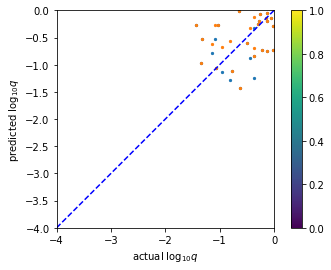

mse of log10q:  0.24906931817531586


In [194]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(torch.log10(q), pred[0].numpy()[:, 2], s=5)
plt.scatter(torch.log10(q), pred[2].numpy()[:, 2], s=5)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print('mse of log10q: ', torch.mean((torch.log10(q) -  pred[0].numpy()[:, 2])**2, dim=0).detach().cpu().item())

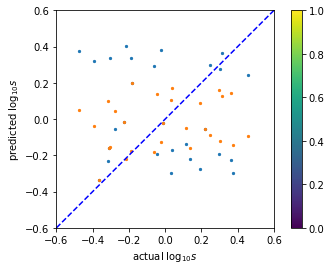

In [195]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(torch.log10(s), pred[0].numpy()[:, 3], s=5)
plt.scatter(torch.log10(s), pred[2].numpy()[:, 3], s=5)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.show()


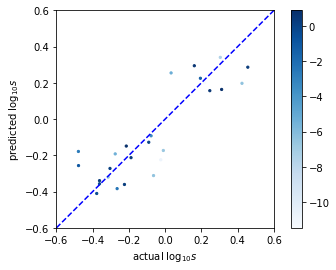

tensor([-0.0101,  0.0326, -0.3145,  0.1609, -0.4789])
[-0.17330465  0.25468883 -0.32041141  0.294357   -0.17867768]
mse of log10s:  0.019067040839979878


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(np.log10(s), pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1), s=5, c=-nll, cmap='Blues')
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.show()
print(torch.log10(s)[-5:])
print((pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1))[-5:])
print('mse of log10s: ', torch.mean((torch.log10(s) -  pred.numpy()[:, 3] * (2 * (np.log10(s.numpy()) * (pred.numpy()[:, 3]) > 0) - 1))**2, dim=0).detach().cpu().item())

1914
tensor(0.2340) tensor(0.0372)
tensor(0.4340) tensor(0.4591)


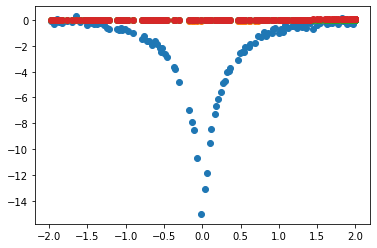

In [196]:
num = 1
print(eventid_list[num])
print(q[num], 10**pred[2][num, 2])
print(s[num], 10**pred[2][num, 3])
plt.scatter(X_even[num, :, 0], X_even[num, :, 1])
plt.scatter(X_even[num, :, 0], X_even[num, :, 2])
plt.scatter(X_even[num, :, 0], X_even[num, :, 3])
plt.scatter(X_even[num, :, 0], X_even[num, :, 4])
plt.show()

In [197]:
pi, normal = model(train_coeffs[[num]].float().to(device))

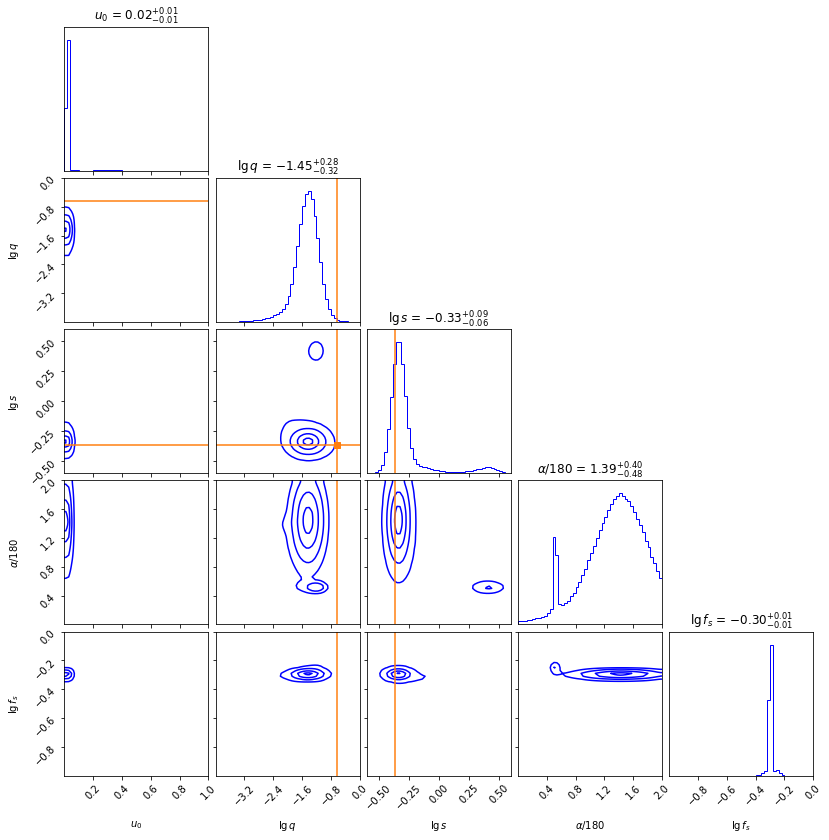

In [198]:
import corner
n = int(1e6)

pi_ = pi.probs.cpu(); loc_ = normal.loc.cpu(); scale_ = normal.scale.cpu()
pi_ = torch.tile(pi_, (n, 1)); loc_ = torch.tile(loc_, (n, 1, 1)); scale_ = torch.tile(scale_, (n, 1, 1))
normal_dist = torch.distributions.Normal(loc_, scale_)
pi_dist = torch.distributions.OneHotCategorical(probs=pi_)
sample = model.sample(pi_dist, normal_dist).numpy()
sample = np.delete(sample, 1, axis=1)
# sample[:, -2] = 2-sample[:, -2]

# pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
# pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
# normal = torch.distributions.Normal(loc, scale)
# pi_dist = torch.distributions.OneHotCategorical(probs=pi)
# sample_gap = model.sample(pi_dist, normal).numpy()
# loglik = normal.log_prob(torch.tensor(sample_gap).unsqueeze(1).expand_as(normal.loc))
# loglik = torch.sum(loglik, dim=2)
# loglik = torch.logsumexp(torch.log(pi_dist.probs) + loglik, dim=1)
# np.savetxt('samples.csv', np.hstack([sample_gap, loglik.reshape(-1, 1)]), fmt='%.5f', delimiter=',', header='u0, lgrho, lgq, lgs, alpha/180, lgfs, loglik')
# sample_gap = np.delete(sample_gap, 1, axis=1)

test_p = [None, None, np.log10(q[num]), np.log10(s[num]), None, None]
truths_full = np.array(test_p)
truths = np.delete(truths_full, 1, axis=-1)

# range_p = [(0.8, 1.2), (-1.6, -1), (0.35, 0.45), (1.1, 1.2), (-0.2, 0.2)] # 53
# range_p = [(0, 0.15), (-2, 0), (-0.4, 0.4), (0, 2), (-0.5, 0)] # 77
range_p = [(0, 1), (-4, 0), (-0.6, 0.6), (0, 2), (-1, 0)]
# range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths, truth_color='C1', 
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            # levels=[sigma_level, 0.7],
            )
# corner.overplot_lines(fig, truths[1], color="C2")
# corner.overplot_points(fig, truths[1][None], marker="s", color="C2")
# corner.corner(sample_gap, fig=fig, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
#             # quantiles=[0.16, 0.5, 0.84], 
#             smooth=1,
#             bins=50,
#             range=range_p,
#             show_titles=True, title_kwargs={"fontsize": 12},
#             truths=truths, truth_color='black', 
#             fill_contours=False, color='red',  no_fill_contours=True,
#             plot_datapoints=False, plot_density=False,
#             # levels=[sigma_level, 0.7],
#             )
# plt.legend()
plt.show()

In [63]:
sample = model.sample(pi, normal).cpu().numpy()
print(sample)
print(torch.log10(q[num]), torch.log10(s[num]))

[[ 0.01193913 -2.7500365  -0.2967439  -0.16648473  1.0071276  -0.4469525 ]]
tensor(-1.4353) tensor(-0.0241)


In [64]:
# qsnormal = torch.distributions.Normal(normal.loc[:, :, [0, 3]], normal.scale[:, :, [0, 3]])
qsnormal = torch.distributions.Normal(normal.loc[:, :, [2, 3]], normal.scale[:, :, [2, 3]])
grid = torch.stack(torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
# grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
# y = torch.tile(Y[[num]], [10000, 1])
# y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, qsnormal, grid[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [65]:
torch.exp(-get_negloglik(pi, normal, torch.log10(q)[[num]].to(device))).detach().cpu(), \
torch.exp(-get_negloglik(pi, normal, model.sample(pi, normal)[:, 2].to(device)).detach().cpu()), \
torch.exp(-model.mdn_loss(pi, normal, model.sample(pi, normal).to(device)).detach().cpu())

(tensor([2.0101e-05]), tensor([0.9964]), tensor(1.7441))

tensor(-1.4353) tensor(-0.0241)
[[ 0.03212756 -2.594217   -0.3789319  -0.15650192  0.9321375  -0.45932835]]


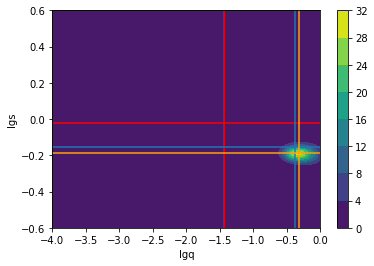

In [66]:
sample = model.sample(pi, normal).detach().cpu().numpy()
x, y = torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100))
plt.xlabel('lgq'); plt.ylabel('lgs')
# x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100))
plt.contourf(x, y, prob.reshape(100, 100))
# plt.contourf(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100), prob.reshape(100, 100).T)
plt.hlines(np.log10(s[num]), -4, 0, colors='red')
plt.vlines(np.log10(q[num]), -0.6, 0.6, colors='red')
# plt.hlines(sample[0, 3], 0, 1)
# plt.vlines(sample[0, 0], -0.6, 0.6)
plt.hlines(sample[0, 3], -4, 0)
plt.vlines(sample[0, 2], -0.6, 0.6)
plt.colorbar()
print(torch.log10(q)[num], torch.log10(s)[num])
print(sample)
plt.hlines(torch.linspace(-0.6, 0.6, 100)[prob.argmax().item()%100], -4, 0, color='orange')
plt.vlines(torch.linspace(-4, 0, 100)[prob.argmax().item()//100], -0.6, 0.6, color='orange')
plt.show()

In [67]:
qsnormal = torch.distributions.Normal(normal.loc[:, :, [0, -2]], normal.scale[:, :, [0, -2]])
grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 2, 100)), dim=-1).reshape(-1, 2)
# grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
# y = torch.tile(Y[[num]], [10000, 1])
# y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, qsnormal, grid[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

[[ 0.03212756 -2.594217   -0.3789319  -0.15650192  0.9321375  -0.45932835]]


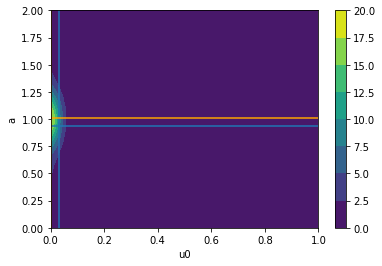

In [68]:
# sample = model.sample(pi, normal).detach().cpu().numpy()
x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 2, 100))
plt.xlabel('u0'); plt.ylabel('a')
# x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100))
plt.contourf(x, y, prob.reshape(100, 100))
plt.hlines(sample[0, -2], 0, 1)
plt.vlines(sample[0, 0], 0, 2)
plt.colorbar()
print(sample)
plt.hlines(torch.linspace(0, 2, 100)[prob.argmax().item()%100], 0, 1, color='orange')
plt.vlines(torch.linspace(0, 1, 100)[prob.argmax().item()//100], 0, 2, color='orange')
plt.show()

In [69]:
sample[0, 0], 10**sample[0, 1], 10**sample[0, 2], 10**sample[0, 3], sample[0, 4]*np.pi, 10**sample[0, 5]

(0.032127555,
 0.0025455576554083478,
 0.41789588068137806,
 0.6974259151363653,
 2.928396288579726,
 0.3472735019834947)

In [70]:
import MulensModel as mm
# sample = model.sample(pi, normal).detach().cpu().numpy()
fs = 10**sample[0, 5]
parameters = { # 0328
        't_0': 0,
        't_E': 1,
        'u_0': 0.1823,
        'rho': 10**sample[0, 1], 
        'q': 0.427, 
        's': 0.3325, 
        'alpha': 4.3029/np.pi*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
mag = - 2.5 * np.log10(fs*magnification + 1-fs) / 0.2
lc = np.stack([times, mag], axis=-1)

In [71]:
sample = model.sample(pi, normal).detach().cpu().numpy()
# fs = 1
parameters = {
        't_0': 0,
        't_E': 1,
        'u_0': sample[0, 0],
        'rho': 10**sample[0, 1], 
        'q': 10**sample[0, 2], 
        's': 10**sample[0, 3], 
        'alpha': sample[0, 4]*180,
    }
modelmm = mm.Model(parameters, coords=None)
times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=1000)
modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
magnification = modelmm.get_magnification(times)
mag = -2.5 * np.log10(fs*magnification + 1-fs) / 0.2
lc_pred = np.stack([times, mag], axis=-1)

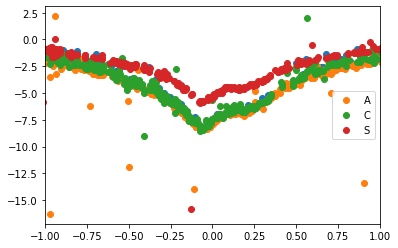

In [39]:
data = []
mode = []
num=11
for root, dirs, files in os.walk(targetdir + 'KMT-2019-BLG-' + eventid_list[num]):
    for f in files:
        if 'V' not in f:
            p = re.compile('___')
            file = open(f'{targetdir}KMT-2019-BLG-{eventid_list[num]}/{f}', 'r+')
            lines = [line for line in file.readlines() if p.search(line) is None]
            file.seek(0)
            file.truncate(0)
            file.writelines(lines)
            file.close()

            data.append(np.loadtxt(f'{targetdir}KMT-2019-BLG-{eventid_list[num]}/{f}'))
            mode.append(f[3])
d = data
data = np.vstack(data)
data = data[np.argsort(data[:, 0])]
params = np.loadtxt(targetdir + 'params.csv', delimiter=',', skiprows=1)
params = params[params[:, 0]==int(eventid_list[num])].flatten()
data[:, 0] = (data[:, 0] - params[1]) / params[2]
data[:, 3] = (data[:, 3] - params[-1]) / 0.2
# plt.scatter(data[:, 0], data[:, 3])
plt.scatter(X_even[num, :, 0], X_even[num, :, 1])
for i in range(len(mode)):
    plt.scatter((d[i][:, 0] - params[1]) / params[2], (d[i][:, 3] - params[-1]) / 0.2, label=mode[i])
plt.xlim(-1, 1)
plt.legend()
plt.show()

tensor(0.7300) 0.7701630920192232
0.06582351515572459


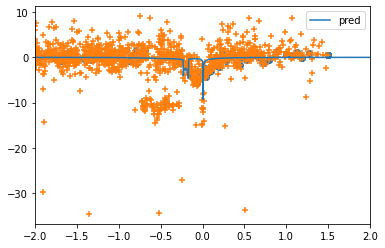

In [46]:
print(q[num], 10**sample[0, 2])
print(10**sample[0, -1])
plt.xlim(-2, 2)
# plt.ylim(-15, 0)
plt.scatter(X_even[num, :, 0], X_even[num, :, 1], marker='o')
plt.scatter(data[:, 0], data[:, 3], marker='+')
# plt.plot(lc[:, 0], lc[:, 1], label='actual', color='red')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], label='pred')
plt.legend()
plt.show()

In [8]:
from scipy.signal import find_peaks
import MulensModel as mm
def get_loglik(pi, loc, scale, x, margin_dim, exp=False):
    shape = x.shape
    loc = loc[..., margin_dim]
    scale = scale[..., margin_dim]
    normal = torch.distributions.Normal(loc, scale)
    x = x.reshape(-1, loc.shape[0], 1).tile(1, loc.shape[-1])
    loglik = normal.log_prob(x).reshape(*shape[:-1], -1)
    loglik = torch.logsumexp(torch.log(pi) + loglik, dim=-1)
    if exp:
        return torch.exp(loglik)
    return loglik

def get_peak_pred(pis, locs, scales, Y, n_step=1000, verbose=False):
    num = len(pis); output_dim = locs.shape[-1]
    pred_global = torch.zeros((num, output_dim))
    pred_global_loglik = torch.zeros((num, output_dim))
    pred_close = torch.zeros((num, output_dim))
    pred_close_loglik = torch.zeros((num, output_dim))
    grid = [torch.linspace(0, 1, n_step),
            torch.linspace(-4, -2, n_step),
            torch.linspace(-4, 0, n_step),
            torch.linspace(-0.6, 0.6, n_step),
            torch.linspace(0, 2, n_step),
            torch.linspace(-1, 0, n_step)]
    for dim in tqdm(range(output_dim)):
        param_list = grid[dim].reshape(-1, 1, 1).tile(1, num, 1) 
        loglik = get_loglik(pis, locs, scales, param_list, margin_dim=dim, exp=False).transpose(1, 0)
        for i in tqdm(range(num)):
            peaks = find_peaks(loglik[i])[0]
            if len(peaks) == 0:
                pred_global[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_close[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_global_loglik[i, dim] = torch.max(loglik[i])
                pred_close_loglik[i, dim] = torch.max(loglik[i])
                if verbose:
                    print('no peak found, use maximum instead')
                    plt.plot(grid[dim], loglik[i])
                    plt.vlines(Y[i, dim], 0, 10, color='red')
                    plt.vlines(grid[dim][torch.argmax(loglik[i])], 0, 10, color='blue')
                    print(Y[i, dim])
                    plt.show()
            else:
                order = torch.argsort(loglik[i, peaks], descending=True)
                global_peak = grid[dim][peaks[order[0]]]
                close_peak = grid[dim][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
                pred_global[i, dim] = global_peak
                pred_close[i, dim] = close_peak
                pred_global_loglik[i, dim] = loglik[i][peaks[order[0]]]
                pred_close_loglik[i, dim] = loglik[i][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
    return pred_global, pred_global_loglik, pred_close, pred_close_loglik

def simulate_lc(t_0, t_E, u_0, lgrho, lgq, lgs, alpha_180, lgfs, times=None, relative_uncertainty=0, n_points=1000, orig=False):
    fs = 10**lgfs
    parameters = {
            't_0': t_0,
            't_E': t_E,
            'u_0': u_0,
            'rho': 10**lgrho, 
            'q': 10**lgq, 
            's': 10**lgs, 
            'alpha': alpha_180*180,
        }
    modelmm = mm.Model(parameters, coords=None)
    if type(times)==type(None):
        times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=n_points)
    modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
    magnification = modelmm.get_magnification(times)
    flux = fs * magnification + (1 - fs)
    flux *= 1 + relative_uncertainty * np.random.randn(len(flux))
    if orig:
        mag = -2.5 * np.log10(flux)
    else:
        mag = -2.5 * np.log10(flux) / 0.2
    lc = np.stack([times, mag], axis=-1)
    return lc

def getfsfb(times, iflux, iferr, t_0, t_E, u_0, lgrho, lgq, lgs, alpha_180, lgfs):
    ''' iflux: data flux values;
    iferr: data flux uncertainties;
    iamp: theoretical magnifications. '''
    parameters = {
            't_0': t_0,
            't_E': t_E,
            'u_0': u_0,
            'rho': 10**lgrho, 
            'q': 10**lgq, 
            's': 10**lgs, 
            'alpha': alpha_180*180,
        }
    modelmm = mm.Model(parameters, coords=None)
    modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
    iamp = modelmm.get_magnification(times)
    sig2 = iferr**2
    wght = iflux/sig2
    d = np.ones(2)
    d[0] = np.sum(wght*iamp)
    d[1] = np.sum(wght)
    b = np.zeros((2,2))
    b[0,0] = np.sum(iamp**2/sig2)
    b[0,1] = np.sum(iamp/sig2)
    b[1,0] = b[0,1]
    b[1,1] = np.sum(1./sig2)
    c = np.linalg.inv(b)
    fs = np.sum(c[0]*d)
    fb = np.sum(c[1]*d)
    fserr = np.sqrt(c[0,0])
    fberr = np.sqrt(c[1,1])
    fmod = fs*iamp+fb
    chi2 = np.sum((iflux-fmod)**2/sig2)
    return chi2,fs,fb,fserr,fberr

In [9]:
import pandas as pd
# tel = pd.read_csv('./kb190371_aligned.csv', skiprows=0, usecols=[0, 2, 5, 6])
# tel = tel[(tel['Tel'] != 'KMTS01') & (tel['Tel'] != 'KMTS41')]
# x_orig = tel[['HJD', 'mag_aligned', 'e_mag_aligned']].to_numpy()
x_orig = np.loadtxt('./kb190371_aligned.csv', delimiter=',', skiprows=1, usecols=(2, 5, 6))
order = np.argsort(x_orig[:, 0])
x_orig = x_orig[order]
err = x_orig[:, -1]
x_orig = x_orig[:, :-1]
t0 = 8592.392; tE = 6.55
x_orig[:, 0] = (x_orig[:, 0] - t0)/tE
ind = (x_orig[:, 0] > -2) * (x_orig[:, 0] < 2)
mbase = x_orig[~ind, 1].mean()
x_orig = x_orig[ind]
err = err[ind]
x = x_orig

In [10]:
from scipy.signal import medfilt
# x[:, 1] = medfilt(x[:, 1], 7)
x[:, 1] = medfilt(x[:, 1], 5)
# x[x[:, 0] < -0.1, 1] = medfilt(x[x[:, 0] < -0.1, 1], 5)
# x[x[:, 0] > 0.1, 1] = medfilt(x[x[:, 0] > 0.1, 1], 5)

602

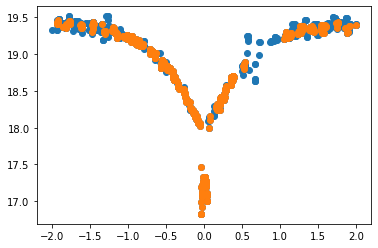

In [11]:
threshold = 0.05
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(x[err<threshold, 0], x[err<threshold, 1])
# plt.xlim(-0.3, 0.3)
len(x[err<threshold, 0])

In [12]:
ind = err < threshold
x = x[ind]
err = err[ind]
x[:, 1] = (x[:, 1] - mbase) / 0.2

(-0.3, 0.3)

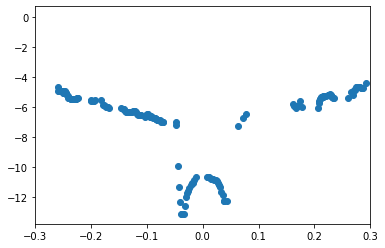

In [13]:
plt.scatter(x[:, 0], x[:, 1])
plt.xlim(-0.3, 0.3)

In [14]:
data = torch.tensor(x.reshape(1, *x.shape))
depth = 3; window_length = 6
data = torchcde.logsig_windows(data, depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(data)

(torch.Size([1, 101, 20]), tensor(0.0006, dtype=torch.float64))

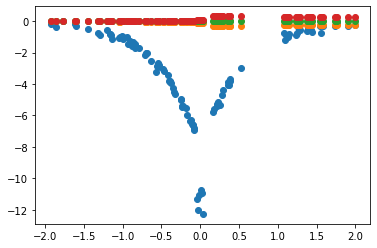

In [15]:
plt.scatter(data[0, :, 0], data[0, :, 1])
plt.scatter(data[0, :, 0], data[0, :, 2])
plt.scatter(data[0, :, 0], data[0, :, 3])
plt.scatter(data[0, :, 0], data[0, :, 4])
train_coeffs.shape, data[:, :, 2:].mean()

In [16]:
with torch.no_grad():
    pi, normal = model(train_coeffs.float().to(device))

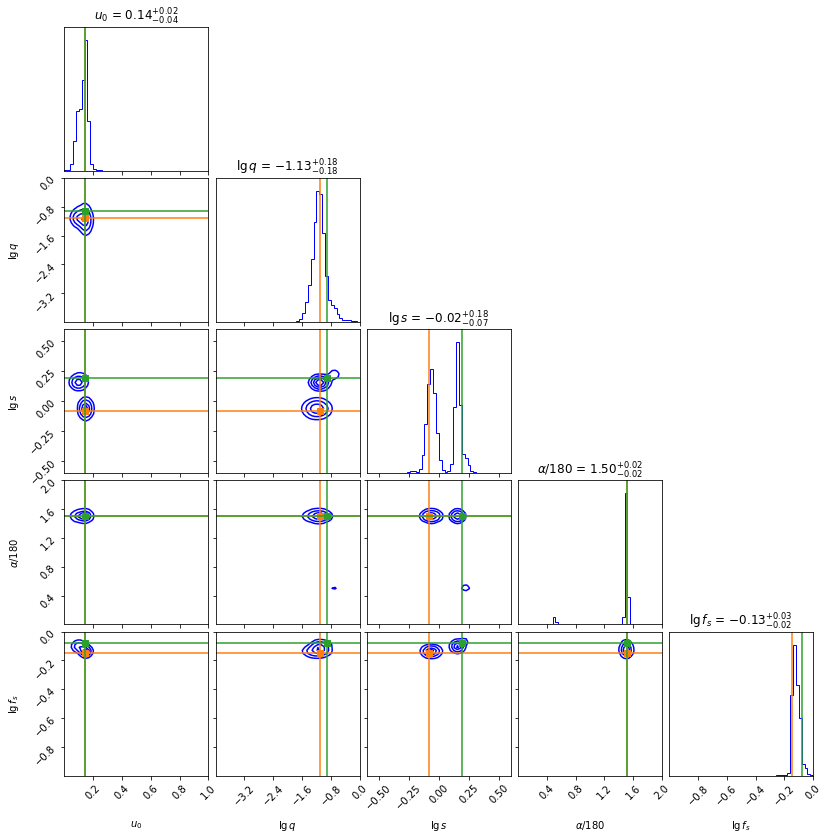

In [41]:
import corner
n = int(1e6)

pi_ = pi.probs.cpu(); loc_ = normal.loc.cpu(); scale_ = normal.scale.cpu()
pi_ = torch.tile(pi_, (n, 1)); loc_ = torch.tile(loc_, (n, 1, 1)); scale_ = torch.tile(scale_, (n, 1, 1))
normal_dist = torch.distributions.Normal(loc_, scale_)
pi_dist = torch.distributions.OneHotCategorical(probs=pi_)
sample = model.sample(pi_dist, normal_dist).numpy()
sample = np.delete(sample, 1, axis=1)
# sample[:, -2] = 2-sample[:, -2]

# pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
# pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
# normal = torch.distributions.Normal(loc, scale)
# pi_dist = torch.distributions.OneHotCategorical(probs=pi)
# sample_gap = model.sample(pi_dist, normal).numpy()
# loglik = normal.log_prob(torch.tensor(sample_gap).unsqueeze(1).expand_as(normal.loc))
# loglik = torch.sum(loglik, dim=2)
# loglik = torch.logsumexp(torch.log(pi_dist.probs) + loglik, dim=1)
# np.savetxt('samples.csv', np.hstack([sample_gap, loglik.reshape(-1, 1)]), fmt='%.5f', delimiter=',', header='u0, lgrho, lgq, lgs, alpha/180, lgfs, loglik')
# sample_gap = np.delete(sample_gap, 1, axis=1)

test_p = [[0.140, np.log10(6.46)-3, np.log10(0.079), np.log10(0.826), 2-1.542/np.pi, 0],
        [0.141, np.log10(6.99)-3, np.log10(0.123), np.log10(1.575), 2-1.544/np.pi, 0]]
fs, fb = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *test_p[0])[1:3]
test_p[0][-1] = np.log10(fs / (fs + fb))
fs, fb = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *test_p[1])[1:3]
test_p[1][-1] = np.log10(fs / (fs + fb))
truths_full = np.array(test_p)
truths = np.delete(truths_full, 1, axis=-1)

# range_p = [(0.8, 1.2), (-1.6, -1), (0.35, 0.45), (1.1, 1.2), (-0.2, 0.2)] # 53
# range_p = [(0, 0.15), (-2, 0), (-0.4, 0.4), (0, 2), (-0.5, 0)] # 77
range_p = [(0, 1), (-4, 0), (-0.6, 0.6), (0, 2), (-1, 0)]
# range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths[0], truth_color='C1', 
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            # levels=[sigma_level, 0.7],
            )
corner.overplot_lines(fig, truths[1], color="C2")
corner.overplot_points(fig, truths[1][None], marker="s", color="C2")
# corner.corner(sample_gap, fig=fig, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
#             # quantiles=[0.16, 0.5, 0.84], 
#             smooth=1,
#             bins=50,
#             range=range_p,
#             show_titles=True, title_kwargs={"fontsize": 12},
#             truths=truths, truth_color='black', 
#             fill_contours=False, color='red',  no_fill_contours=True,
#             plot_datapoints=False, plot_density=False,
#             # levels=[sigma_level, 0.7],
#             )
# plt.legend()
plt.show()

In [38]:
pred = get_peak_pred(pi.probs.cpu(), normal.loc.cpu(), normal.scale.cpu(), truths_full[[0]])

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [[ 0.14       -2.18976748 -1.10237291 -0.08301995  1.50916616 -0.14947095]
 [ 0.03803494 -2.15552282 -0.91009489  0.19728056  1.50852954 -0.08044287]]
pred global:  [0.09611341411869573, -3.0770771503448486, -1.1251251697540283, 0.15555556118488312, 1.5055055618286133, -0.09789738730166267] prob density:  120100.25
pred close:  [0.14714714884757996, -3.0770771503448486, -1.1251251697540283, -0.06306307017803192, 1.5055055618286133, -0.09789738730166267] prob density:  91571.76


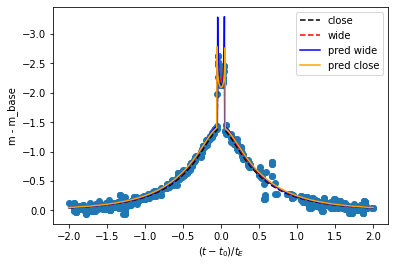

In [42]:
plt.xlabel(r'$(t - t_0)/t_E$')
plt.ylabel(r'm - m_base')
# plt.xlim(-0.3, 0.3)
plt.scatter(x_orig[:, 0], x_orig[:, 1]-mbase)
sol_wide = pred[0][0].tolist()
fs_w, fb_w = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *pred[0][0].tolist())[1:3]
sol_wide[-1] = np.log10(fs_w / (fs_w + fb_w))
sol_close = pred[2][0].tolist()
fs_c, fb_c = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *pred[2][0].tolist())[1:3]
sol_close[-1] = np.log10(fs_w / (fs_w + fb_w))

# truths_full[1][-1] = np.log10(0.206/(0.206+0.329))
truths_full[1][0] = truths_full[1][0] - 10**truths_full[1][2]/(1+10**truths_full[1][2])*(10**truths_full[1][3]-1/10**truths_full[1][3])
sol_wide[0] = sol_wide[0] - 10**sol_wide[2]/(1+10**sol_wide[2])*(10**sol_wide[3]-1/10**sol_wide[3])

lc_true_0 = simulate_lc(0, 1, *truths_full[0].tolist(), orig=True)
lc_true_1 = simulate_lc(0, 1, *truths_full[1].tolist(), orig=True)
lc_pred_g = simulate_lc(0, 1, *sol_wide, orig=True)
lc_pred_c = simulate_lc(0, 1, *sol_close, orig=True)
plt.plot(lc_true_0[:, 0], lc_true_0[:, 1], color='black', linestyle='dashed', label='close')
plt.plot(lc_true_1[:, 0], lc_true_1[:, 1], color='red', linestyle='dashed', label='wide')
plt.plot(lc_pred_g[:, 0], lc_pred_g[:, 1], color='blue', label='pred wide')
plt.plot(lc_pred_c[:, 0], lc_pred_c[:, 1], color='orange', label='pred close')
# plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
print('ground truth: ', truths_full)
print('pred global: ', sol_wide, 'prob density: ', np.exp(pred[1].numpy().sum()))
print('pred close: ', sol_close, 'prob density: ', np.exp(pred[3].numpy().sum()))
# print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [20]:
print('close', getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *truths_full[0].tolist()))
print('wide', getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *truths_full[1].tolist()))
print('pred close', getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *pred[2][0].tolist()))
print('pred wide', getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *pred[0][0].tolist()))

close (22622.359299240565, 0.7125413189494636, 0.29272471046018333, 0.00027317928390811595, 0.0006532607136832777)
wide (1385446.0409688535, 0.8912981102137163, 0.18137119974220806, 0.00038212145467167067, 0.0007400811166448833)
pred close (468032.8319993871, 0.8022461229440052, 0.16235160113274016, 0.0003181621292611281, 0.0007083417134224916)
pred wide (944705.9211985768, 0.8243901886525373, 0.20844304001110192, 0.00033993537742579144, 0.0007115263394526979)
